# Лабораторная работа 5. Свёрточные сети

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import torchvision
import random
import numpy as np
import matplotlib.pyplot as plt

# отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

In [2]:
manualSeed = 42
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  42


Загрузим датасет [`FashionMNIST`](https://docs.pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html) и визуализируем примеры изображений из него.

In [3]:
batch_size = 64
transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])
train_set = torchvision.datasets.FashionMNIST(root='FashionMNIST', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
val_set = torchvision.datasets.FashionMNIST(root='FashionMNIST', train=False, download=True, transform=transform)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)

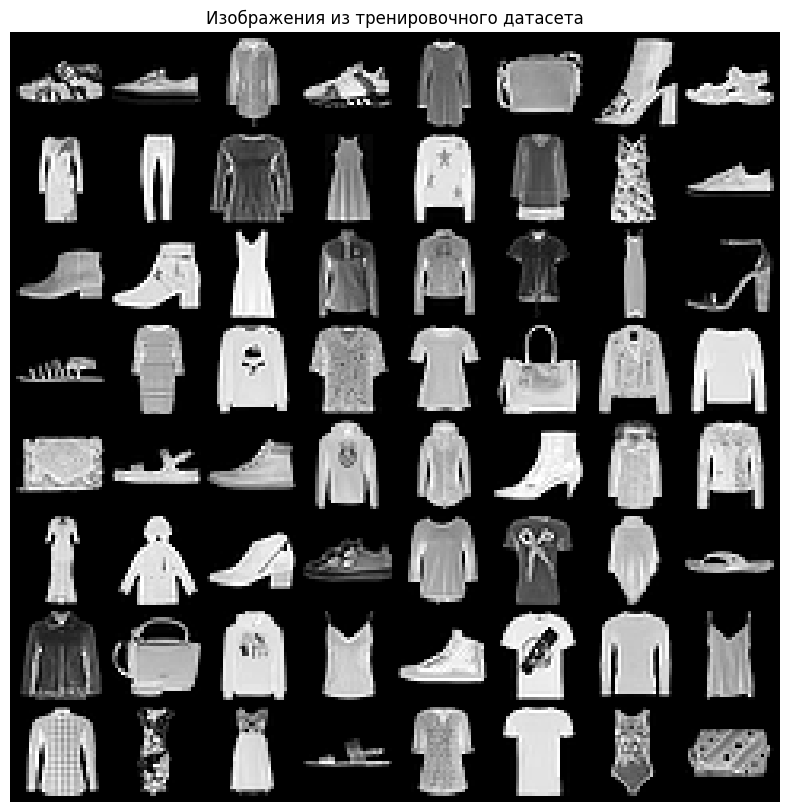

In [4]:
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

real_batch = next(iter(train_loader))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

plt.figure(figsize=(10,10))
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device), normalize=True).cpu(),(1,2,0)))
plt.axis("off")
plt.title("Изображения из тренировочного датасета")
plt.show()

#### Задание 1.
Постройте свёрточную сеть `LeNet-5`. Используя созданные `train_loader` и `val_loader`, обучите модель распознавать одежду из датасета `FashionMNIST`.

Поэкспериментируйте с гиперпараметрами и постарайтесь достичь точности (`accuracy`) распознавания не менее `0.8` на валидационной подвыборке.

In [7]:
# Определение модели LeNet-5
class LeNet5(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet5, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 16 * 5 * 5)
        x = self.classifier(x)
        return x

# Загрузка данных
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_set = datasets.FashionMNIST(root='FashionMNIST', train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)

val_set = datasets.FashionMNIST(root='FashionMNIST', train=False, download=True, transform=transform)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False, num_workers=2)

# Инициализация модели, оптимизатора и функции потерь
model = LeNet5(num_classes=10)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Обучение модели
num_epochs = 10
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Эпоха {epoch+1}/{num_epochs}, Потери: {running_loss/len(train_loader):.4f}")

    # Валидация
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Точность на валидационном наборе: {accuracy:.2f}%")

print("Обучение завершено!")


Эпоха 1/10, Потери: 0.5864
Точность на валидационном наборе: 84.89%
Эпоха 2/10, Потери: 0.3708
Точность на валидационном наборе: 87.24%
Эпоха 3/10, Потери: 0.3199
Точность на валидационном наборе: 88.20%
Эпоха 4/10, Потери: 0.2908
Точность на валидационном наборе: 88.30%
Эпоха 5/10, Потери: 0.2692
Точность на валидационном наборе: 89.03%
Эпоха 6/10, Потери: 0.2515
Точность на валидационном наборе: 89.50%
Эпоха 7/10, Потери: 0.2371
Точность на валидационном наборе: 89.17%
Эпоха 8/10, Потери: 0.2244
Точность на валидационном наборе: 89.69%
Эпоха 9/10, Потери: 0.2094
Точность на валидационном наборе: 89.73%
Эпоха 10/10, Потери: 0.1979
Точность на валидационном наборе: 90.47%
Обучение завершено!


#### Задание 2.
Поэкспериментировуйте с параметрами `LeNet-5` и найдите оптимальную архитектуру для `FashionMNIST`.  

Параметры для подбора:
- количество свёрточных слоев
- функция активации (Tanh, ReLU)
- способ субдискретизации (Average, Max)
- размер фильтров
- количество фильтров

Какую наилучшую точность получилось достичь на валидационной подвыборке?

In [9]:
# Определение модели LeNet-5 с возможностью настройки
class ConfigurableLeNet5(nn.Module):
    def __init__(self, num_classes=10, conv_layers=2, activation='ReLU', pooling='Max',
                 filter_sizes=[5, 5], num_filters=[6, 16]):
        super(ConfigurableLeNet5, self).__init__()
        self.features = nn.Sequential()
        in_channels = 1  # Для FashionMNIST - 1 канал (grayscale)

        for i in range(conv_layers):
            padding = filter_sizes[i] // 2 if i == 0 else 0  # Padding для первого слоя, чтобы сохранить размер
            self.features.add_module(f'conv{i+1}', nn.Conv2d(in_channels, num_filters[i],
                                                            kernel_size=filter_sizes[i], padding=padding))
            if activation == 'ReLU':
                self.features.add_module(f'relu{i+1}', nn.ReLU())
            elif activation == 'Tanh':
                self.features.add_module(f'tanh{i+1}', nn.Tanh())

            if pooling == 'Max':
                self.features.add_module(f'pool{i+1}', nn.MaxPool2d(kernel_size=2, stride=2))
            elif pooling == 'Average':
                self.features.add_module(f'pool{i+1}', nn.AvgPool2d(kernel_size=2, stride=2))

            in_channels = num_filters[i]

        # Вычисление размера выхода сверточных слоев для полносвязных слоев
        dummy_input = torch.randn(1, 1, 28, 28)  # Размер изображения FashionMNIST
        with torch.no_grad():
            output = self.features(dummy_input)
            flattened_size = output.view(-1).shape[0]

        self.classifier = nn.Sequential(
            nn.Linear(flattened_size, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Загрузка данных (как в предыдущем примере)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_set = datasets.FashionMNIST(root='FashionMNIST', train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)

val_set = datasets.FashionMNIST(root='FashionMNIST', train=False, download=True, transform=transform)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False, num_workers=2)

# Функция для обучения и валидации
def train_and_validate(model, optimizer, criterion, num_epochs=10, device='cpu'):
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Эпоха {epoch+1}/{num_epochs}, Потери: {running_loss/len(train_loader):.4f}")

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f"Точность на валидационном наборе: {accuracy:.2f}%")
    return accuracy

# Пример использования и экспериментов
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

# Список экспериментов для запуска
experiments = [
    {'conv_layers': 2, 'activation': 'ReLU', 'pooling': 'Max', 'filter_sizes': [5, 5], 'num_filters': [6, 16]},  # Базовая LeNet-5 (для сравнения)
    {'conv_layers': 2, 'activation': 'ReLU', 'pooling': 'Max', 'filter_sizes': [3, 3], 'num_filters': [12, 24]},  # Меньшие фильтры, больше фильтров
    {'conv_layers': 2, 'activation': 'ReLU', 'pooling': 'Max', 'filter_sizes': [5, 5], 'num_filters': [12, 32]},  # Больше фильтров
    {'conv_layers': 2, 'activation': 'Tanh', 'pooling': 'Average', 'filter_sizes': [5, 5], 'num_filters': [6, 16]},  # Tanh и Average
    {'conv_layers': 3, 'activation': 'ReLU', 'pooling': 'Max', 'filter_sizes': [3, 3, 3], 'num_filters': [8, 16, 32]},  # 3 слоя
    {'conv_layers': 2, 'activation': 'ReLU', 'pooling': 'Max', 'filter_sizes': [3, 5], 'num_filters': [16, 32]},  # Разные размеры фильтров
]

results = {}
for i, params in enumerate(experiments):
    print(f"\nЭксперимент {i+1}: {params}")
    model = ConfigurableLeNet5(**params)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    accuracy = train_and_validate(model, optimizer, criterion, device=device)
    results[f"Эксперимент {i+1}"] = accuracy

print("\nРезультаты всех экспериментов:")
for name, accuracy in results.items():
    print(f"{name}: {accuracy:.2f}%")



Эксперимент 1: {'conv_layers': 2, 'activation': 'ReLU', 'pooling': 'Max', 'filter_sizes': [5, 5], 'num_filters': [6, 16]}
Эпоха 1/10, Потери: 0.5965
Точность на валидационном наборе: 84.34%
Эпоха 2/10, Потери: 0.3814
Точность на валидационном наборе: 85.86%
Эпоха 3/10, Потери: 0.3254
Точность на валидационном наборе: 87.38%
Эпоха 4/10, Потери: 0.2935
Точность на валидационном наборе: 88.56%
Эпоха 5/10, Потери: 0.2715
Точность на валидационном наборе: 89.30%
Эпоха 6/10, Потери: 0.2535
Точность на валидационном наборе: 89.41%
Эпоха 7/10, Потери: 0.2368
Точность на валидационном наборе: 89.42%
Эпоха 8/10, Потери: 0.2280
Точность на валидационном наборе: 89.38%
Эпоха 9/10, Потери: 0.2136
Точность на валидационном наборе: 89.99%
Эпоха 10/10, Потери: 0.2022
Точность на валидационном наборе: 89.61%

Эксперимент 2: {'conv_layers': 2, 'activation': 'ReLU', 'pooling': 'Max', 'filter_sizes': [3, 3], 'num_filters': [12, 24]}
Эпоха 1/10, Потери: 0.5392
Точность на валидационном наборе: 85.15%
Эпох

#### Задание 3 (факультативное).
Построить свёрточную сеть по одной из рассмотренных архитектур (AlexNet, VGG, Inception, ResNet) и обучить её распознаванию MNIST (FashionMNIST, CIFAR10).

#### Задание 4 (факультативное).
Прочитать параграф 5.3 в учебнике С. Николенко и др. (стр. 199–206) и воспроизвести рассмотренные там нейронные сети на TensorFlow и Keras.